In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# gdoc notes link: https://docs.google.com/document/d/1cjXIWAZjWP8KMultOzcyQ4vc6-9tzu3A9N6552qh1cU/edit

#Challenge 1

In [ ]:
# pull last month of august through ~sept 22nd each year
# exclude 2020 due to COVID

weeks_for_2019 = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_190921.txt", 
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190914.txt", 
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190907.txt", 
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190831.txt",
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190824.txt"]

weeks_for_2018 = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_180922.txt",
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180915.txt",
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180908.txt",
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180901.txt",
                 "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180825.txt"]

data_2019 = [pd.read_csv(s) for s in weeks_for_2019]
data_2018 = [pd.read_csv(s) for s in weeks_for_2018]
all_data = data_2018+data_2019

#Initially, we looked at combining data from several years; this caused problems with sorting later, and we pulled back to a single year.

#df = pd.concat(all_data, ignore_index=True)
#df = pd.concat(data_2018, ignore_index=True)
df = pd.concat(data_2019, ignore_index=True)

#Challenge 2

In [ ]:
# Preparing the data for further processing.

# create a datetime field from date and time fields. 
df['date_time'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Create a single turnstile ID field to filter with.
df['TURNSTILE_ID'] = df['C/A']+'_'+ df['UNIT']+'_' + df['SCP']+'_' + df['STATION']

# Fix the wonky exits column title.
df.rename(columns={'EXITS                                                               ': 'EXITS'}, inplace=True)

#Sort by the new fields.
df = df.sort_values(['TURNSTILE_ID', 'date_time'])


In [ ]:
#Identify: What are the duplicated turnstiles/dates in the data?
df.groupby(["TURNSTILE_ID","DATE","TIME"])["ENTRIES"].count().reset_index().sort_values(by="ENTRIES",ascending=False).head(10)

,TURNSTILE_ID,DATE,TIME,ENTRIES
638579,R101_R001_02-00-00_SOUTH FERRY,08/22/2019,05:00:00,2
989874,R622_R123_00-00-06_FRANKLIN AV,08/22/2019,04:59:02,2
990087,R622_R123_00-00-07_FRANKLIN AV,08/22/2019,04:59:02,2
639574,R101_R001_02-00-04_SOUTH FERRY,09/17/2019,05:00:00,2
180059,H039_R375_00-00-01_NEW LOTS,09/13/2019,05:00:00,2
709838,R161A_R452_01-00-02_72 ST,08/26/2019,21:00:00,2
179849,H039_R375_00-00-00_NEW LOTS,09/13/2019,05:00:00,2
640204,R101_R001_02-00-07_SOUTH FERRY,09/17/2019,05:00:00,2
684126,R138_R293_00-03-01_34 ST-PENN STA,08/24/2019,06:00:00,1
684165,R138_R293_00-03-01_34 ST-PENN STA,08/30/2019,22:00:00,1


In [ ]:
df.shape

(1026240, 13)

In [ ]:
#df_2[df_2["TURNSTILE_ID"] == "R101_R001_02-00-00_SOUTH FERRY" , df_2["DATE"] =="09/14/2018" , df_2["TIME"] == "05:00:00"]
#(turnstiles_df["DATE_TIME"].dt.date == datetime.datetime(2016, 9, 16).date())

themask = ((df["TURNSTILE_ID"] == "R622_R123_00-00-06_FRANKLIN AV" ) & (df["date_time"].dt.date == datetime.datetime(2019,8,22).date()))

df[themask].head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,TURNSTILE_ID
1018982,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,00:00:00,REGULAR,10088508,12195136,2019-08-22 00:00:00,R622_R123_00-00-06_FRANKLIN AV
1018983,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,04:00:00,REGULAR,10088520,12195190,2019-08-22 04:00:00,R622_R123_00-00-06_FRANKLIN AV
1018984,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,04:59:02,REGULAR,10088529,12195193,2019-08-22 04:59:02,R622_R123_00-00-06_FRANKLIN AV
1018985,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,04:59:02,RECOVR AUD,10088530,12195193,2019-08-22 04:59:02,R622_R123_00-00-06_FRANKLIN AV
1018986,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,05:01:42,REGULAR,10088530,12195193,2019-08-22 05:01:42,R622_R123_00-00-06_FRANKLIN AV
1018987,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,05:01:54,RECOVR AUD,10088530,12195193,2019-08-22 05:01:54,R622_R123_00-00-06_FRANKLIN AV
1018988,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,08:00:00,REGULAR,10088756,12195232,2019-08-22 08:00:00,R622_R123_00-00-06_FRANKLIN AV
1018989,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,12:00:00,REGULAR,10089292,12195348,2019-08-22 12:00:00,R622_R123_00-00-06_FRANKLIN AV
1018990,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,16:00:00,REGULAR,10089523,12195550,2019-08-22 16:00:00,R622_R123_00-00-06_FRANKLIN AV
1018991,R622,R123,00-00-06,FRANKLIN AV,2345S,IRT,08/22/2019,20:00:00,REGULAR,10089733,12196316,2019-08-22 20:00:00,R622_R123_00-00-06_FRANKLIN AV


In [ ]:
# We scanned a few duplicates (see cell above), and chose to drop the second of the two duplicate rows (by turnstile_id and date_time)
df = df.drop_duplicates(subset=["TURNSTILE_ID","date_time"],keep="first")

In [ ]:
df.shape

(1026232, 13)

#Challenge 3

In [ ]:
#First, note that we are using .first for entries, after grouping by date. Because the entries are sorted ascending by date/time, this means that the value assigned to a day
#will be just after midnight, and heavily influenced by the previous day.
df_events_per_day = df.groupby(["TURNSTILE_ID","DATE"],as_index=False)["ENTRIES", "C/A", "UNIT", "SCP", "STATION","TIME", "date_time"].first()


#In order to solve this off-by-one issue, we replace the date with the previous day's date. 
df_events_per_day[["previous_date","previous_entries"]] = df_events_per_day.groupby(["TURNSTILE_ID"])["DATE","ENTRIES"].apply(lambda grp: grp.shift(1))


df_events_per_day.drop(columns=['DATE'], axis=1, inplace=True)
df_events_per_day.rename({'previous_date' : 'DATE'}, axis=1, inplace=True)
df['date_time'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

df_events_per_day.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,TURNSTILE_ID,ENTRIES,C/A,UNIT,SCP,STATION,TIME,date_time,DATE,previous_entries
0,A002_R051_02-00-00_59 ST,7170294,A002,R051,02-00-00,59 ST,00:00:00,2019-08-17,NaN,NaN
1,A002_R051_02-00-00_59 ST,7170943,A002,R051,02-00-00,59 ST,00:00:00,2019-08-18,08/17/2019,7170294.0
2,A002_R051_02-00-00_59 ST,7171363,A002,R051,02-00-00,59 ST,00:00:00,2019-08-19,08/18/2019,7170943.0
3,A002_R051_02-00-00_59 ST,7172478,A002,R051,02-00-00,59 ST,00:00:00,2019-08-20,08/19/2019,7171363.0
4,A002_R051_02-00-00_59 ST,7173517,A002,R051,02-00-00,59 ST,00:00:00,2019-08-21,08/20/2019,7172478.0


In [ ]:
#Next, remove the first day's worth of data, since it will be associated with a nonexistent day.
df_events_per_day.dropna(subset=["DATE"],axis=0,inplace=True)
df_events_per_day.head(5)

,TURNSTILE_ID,ENTRIES,C/A,UNIT,SCP,STATION,TIME,date_time,DATE,previous_entries
1,A002_R051_02-00-00_59 ST,7170943,A002,R051,02-00-00,59 ST,00:00:00,2019-08-18,08/17/2019,7170294.0
2,A002_R051_02-00-00_59 ST,7171363,A002,R051,02-00-00,59 ST,00:00:00,2019-08-19,08/18/2019,7170943.0
3,A002_R051_02-00-00_59 ST,7172478,A002,R051,02-00-00,59 ST,00:00:00,2019-08-20,08/19/2019,7171363.0
4,A002_R051_02-00-00_59 ST,7173517,A002,R051,02-00-00,59 ST,00:00:00,2019-08-21,08/20/2019,7172478.0
5,A002_R051_02-00-00_59 ST,7174625,A002,R051,02-00-00,59 ST,00:00:00,2019-08-22,08/21/2019,7173517.0


In [ ]:
#That's odd! Some of the turnstiles are counting backwards.
df_events_per_day[ df_events_per_day["ENTRIES"] < df_events_per_day["previous_entries"] ].head(5)

,TURNSTILE_ID,ENTRIES,C/A,UNIT,SCP,STATION,TIME,date_time,DATE,previous_entries
1339,A011_R080_01-03-00_57 ST-7 AV,885829355,A011,R080,01-03-00,57 ST-7 AV,00:00:00,2019-08-21,08/20/2019,885829659.0
1340,A011_R080_01-03-00_57 ST-7 AV,885828839,A011,R080,01-03-00,57 ST-7 AV,00:00:00,2019-08-22,08/21/2019,885829355.0
1341,A011_R080_01-03-00_57 ST-7 AV,885828245,A011,R080,01-03-00,57 ST-7 AV,00:00:00,2019-08-23,08/22/2019,885828839.0
1342,A011_R080_01-03-00_57 ST-7 AV,885827671,A011,R080,01-03-00,57 ST-7 AV,00:00:00,2019-08-24,08/23/2019,885828245.0
1343,A011_R080_01-03-00_57 ST-7 AV,885827233,A011,R080,01-03-00,57 ST-7 AV,00:00:00,2019-08-25,08/24/2019,885827671.0


In [ ]:
#Here's where we identified cases where 
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["previous_entries"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0 due to turnstile behavior, or maintenance?
        print(row["STATION"], row["DATE"], row["ENTRIES"], row["previous_entries"])
        counter = min(row["ENTRIES"], row["previous_entries"])
    if min(row["ENTRIES"], row["previous_entries"]) < 10000 and max(row["ENTRIES"], row["previous_entries"]) > 20000:
      #This is another, similar check. 
        return min(row["ENTRIES"], row["previous_entries"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [ ]:
df_events_per_day["DAILY_ENTRIES"] = df_events_per_day.apply(get_daily_counts, axis=1, max_counter=86400)

57 ST-7 AV 08/24/2019 458755 7.0
49 ST 09/07/2019 12 6170094.0
14 ST-UNION SQ 08/20/2019 451 303204.0
BOTANIC GARDEN 09/11/2019 716 171608.0
NECK RD 08/19/2019 459073 68448066.0
SHEEPSHEAD BAY 09/15/2019 275 112691.0
BOROUGH HALL 09/02/2019 143 1599329.0
DEKALB AV 08/21/2019 1638739 805417.0
DEKALB AV 09/06/2019 460787 6805255.0
4AV-9 ST 08/21/2019 138 290539.0
BAY RIDGE AV 09/09/2019 73 6697765.0
BAY PKWY 09/19/2019 875479593 775219651.0
CONEY IS-STILLW 08/20/2019 458754 3774.0
BEDFORD AV 08/22/2019 721 915984.0
JEFFERSON ST 09/18/2019 590840 9156730.0
CHAUNCEY ST 09/17/2019 134 1478959.0
JFK JAMAICA CT1 09/06/2019 597 479848.0
METROPOLITAN AV 09/18/2019 85 771630.0
135 ST 09/03/2019 67 202729.0
125 ST 09/18/2019 222 6053291.0
96 ST 08/27/2019 26 1652502.0
14 ST 08/21/2019 22 2129136933.0
14 ST 08/21/2019 21 13593836.0
14 ST 08/21/2019 27 7808518.0
14 ST 08/21/2019 21 2129136817.0
14 ST 08/21/2019 28 13594033.0
14 ST 08/21/2019 21 7809012.0
CHAMBERS ST 09/15/2019 80 2781090.0
WORLD TR

(166028, 11)

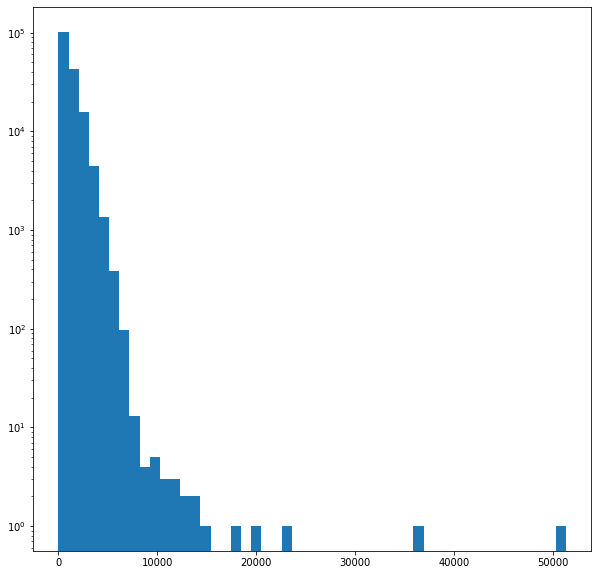

In [ ]:
#Plot the number of entries per day as a histogram to examine the shape of the data. It looks pretty good- roughly what you'd expect, where there is little activity much of the time. 
plt.figure(figsize = [10,10])
plt.hist(df_events_per_day["DAILY_ENTRIES"],50,log=True);
# we will drop outliers
df_events_per_day.shape

In [ ]:
#explore what the high-end outliers look like
df_events_per_day[df_events_per_day["DAILY_ENTRIES"] > 20000].groupby(["STATION"]).head()

#if min(entries, previous_entries)<10000 and max(entries, previous entries)>20000: daily entries = min(entries, previous entries)

#df_events_per_day[(df_events_per_day["STATION"] == "NECK RD") & (df_events_per_day["DATE"] == "8/20/2019")].head()
#df_events_per_day[(df_events_per_day["STATION"] == "AVENUE H") & (df_events_per_day["DATE"] == "09/06/2019")]
df_events_per_day.shape

(166028, 11)

In [ ]:
#Examining the US Daily Open. Is it special?
df_events_per_day[(df_events_per_day["DATE"] > '08/26/2019') & (df_events_per_day["DATE"] < '09/08/2019')]

,TURNSTILE_ID,ENTRIES,C/A,UNIT,SCP,STATION,TIME,date_time,DATE,previous_entries,DAILY_ENTRIES
11,A002_R051_02-00-00_59 ST,7179982,A002,R051,02-00-00,59 ST,00:00:00,2019-08-28 00:00:00,08/27/2019,7178840.0,1142.0
12,A002_R051_02-00-00_59 ST,7181051,A002,R051,02-00-00,59 ST,00:00:00,2019-08-29 00:00:00,08/28/2019,7179982.0,1069.0
13,A002_R051_02-00-00_59 ST,7182148,A002,R051,02-00-00,59 ST,00:00:00,2019-08-30 00:00:00,08/29/2019,7181051.0,1097.0
14,A002_R051_02-00-00_59 ST,7183242,A002,R051,02-00-00,59 ST,00:00:00,2019-08-31 00:00:00,08/30/2019,7182148.0,1094.0
15,A002_R051_02-00-00_59 ST,7184008,A002,R051,02-00-00,59 ST,00:00:00,2019-09-01 00:00:00,08/31/2019,7183242.0,766.0
...,...,...,...,...,...,...,...,...,...,...,...
170945,TRAM2_R469_00-05-01_RIT-ROOSEVELT,5554,TRAM2,R469,00-05-01,RIT-ROOSEVELT,01:00:00,2019-09-04 01:00:00,09/03/2019,5554.0,0.0
170946,TRAM2_R469_00-05-01_RIT-ROOSEVELT,5554,TRAM2,R469,00-05-01,RIT-ROOSEVELT,01:00:00,2019-09-05 01:00:00,09/04/2019,5554.0,0.0
170947,TRAM2_R469_00-05-01_RIT-ROOSEVELT,5554,TRAM2,R469,00-05-01,RIT-ROOSEVELT,01:00:00,2019-09-06 01:00:00,09/05/2019,5554.0,0.0
170948,TRAM2_R469_00-05-01_RIT-ROOSEVELT,5554,TRAM2,R469,00-05-01,RIT-ROOSEVELT,01:00:00,2019-09-07 01:00:00,09/06/2019,5554.0,0.0


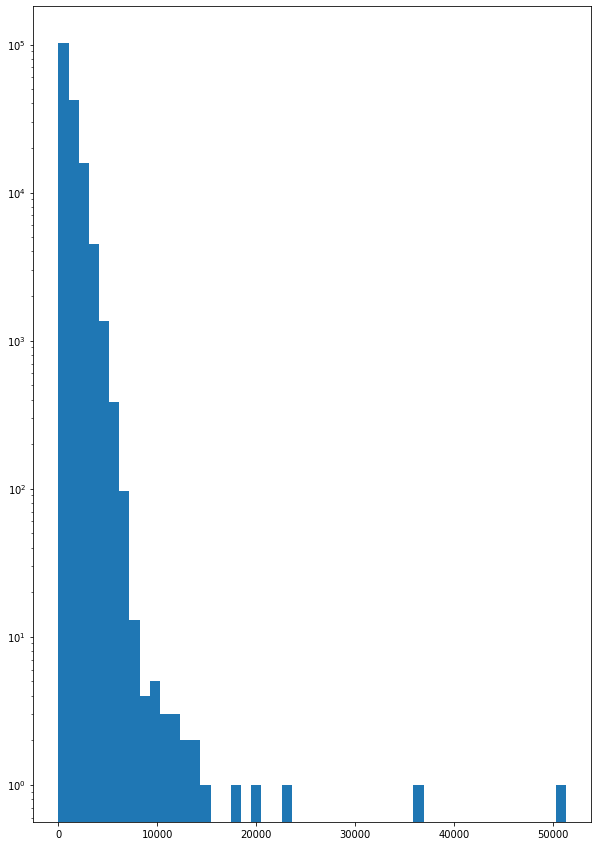

In [ ]:
plt.figure(figsize = [10,15])
plt.hist(df_events_per_day["DAILY_ENTRIES"],50,log=True);

In [ ]:
#remove the daily_entries entries where daily_enries == 0

In [ ]:
yearmark = pd.Timestamp('20190101')

#Challenge 4

We will plot the daily time series for a single turnstile.



In [ ]:
chosen_id = 'A002_R051_02-00-00_59 ST'

df_oneturnstile_daily = df_events_per_day[df_events_per_day['TURNSTILE_ID']==chosen_id]
df_oneturnstile_daily.head(5)

,TURNSTILE_ID,ENTRIES,C/A,UNIT,SCP,STATION,TIME,date_time,DATE,previous_entries,DAILY_ENTRIES
1,A002_R051_02-00-00_59 ST,7170943,A002,R051,02-00-00,59 ST,00:00:00,2019-08-18,08/17/2019,7170294.0,649.0
2,A002_R051_02-00-00_59 ST,7171363,A002,R051,02-00-00,59 ST,00:00:00,2019-08-19,08/18/2019,7170943.0,420.0
3,A002_R051_02-00-00_59 ST,7172478,A002,R051,02-00-00,59 ST,00:00:00,2019-08-20,08/19/2019,7171363.0,1115.0
4,A002_R051_02-00-00_59 ST,7173517,A002,R051,02-00-00,59 ST,00:00:00,2019-08-21,08/20/2019,7172478.0,1039.0
5,A002_R051_02-00-00_59 ST,7174625,A002,R051,02-00-00,59 ST,00:00:00,2019-08-22,08/21/2019,7173517.0,1108.0


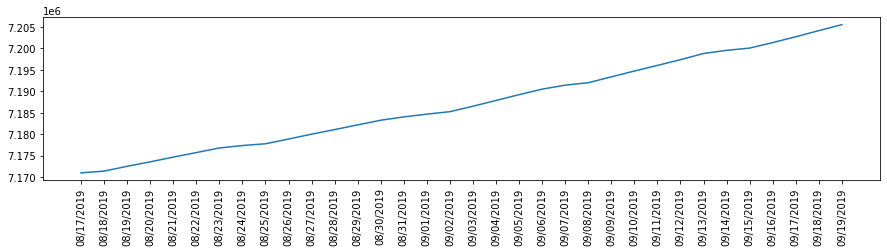

In [ ]:
%matplotlib inline

plt.figure(figsize=(15,3))
plt.plot(df_oneturnstile_daily['DATE'],df_oneturnstile_daily['ENTRIES'])
plt.xticks(rotation='vertical')
plt.show()


In [ ]:
#df.groupby(['TURNSTILE_ID','DATE'])['TIME'].min().reset_index().sort_values(by='TIME',ascending=False)

#Challenge 5


Group turnstiles in the same control area/unit/station.

In [ ]:
# same value for the C/A, UNIT and STATION columns, different values for the SCP column.
df_events_per_day['turnstile_group'] = df_events_per_day['C/A']+'_'+ df_events_per_day['UNIT']+'_' + df_events_per_day['STATION']

df_events_per_day.groupby(['turnstile_group','DATE'])['DAILY_ENTRIES'].sum()

turnstile_group           DATE      
A002_R051_59 ST           08/17/2019     7640.0
                          08/18/2019     6135.0
                          08/19/2019    11387.0
                          08/20/2019    11906.0
                          08/21/2019    11957.0
                                         ...   
TRAM2_R469_RIT-ROOSEVELT  09/15/2019     4084.0
                          09/16/2019     3246.0
                          09/17/2019     3488.0
                          09/18/2019     3431.0
                          09/19/2019     3629.0
Name: DAILY_ENTRIES, Length: 25349, dtype: float64

#Challenge 6

Combine everything in each station, and create daily time series.

In [ ]:
df_daily_station = df_events_per_day.groupby(['STATION','DATE'])['DAILY_ENTRIES', 'date_time', 'DATE'].sum().reset_index()
df_daily_station["day_of_week"] = pd.to_datetime(df_daily_station['DATE']).dt.day_name()
df_daily_station.to_csv("Csv_cleaned.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


#Challenge 7

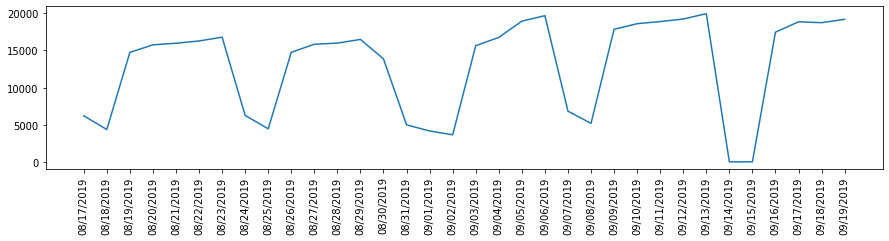

In [ ]:
df_onestation_daily = df_daily_station[df_daily_station['STATION']=='1 AV']



plt.figure(figsize=(15,3))
plt.plot(df_onestation_daily['DATE'],df_onestation_daily['DAILY_ENTRIES'])
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
df_events_per_day.head()

,TURNSTILE_ID,ENTRIES,C/A,UNIT,SCP,STATION,TIME,date_time,DATE,previous_entries,DAILY_ENTRIES
1,A002_R051_02-00-00_59 ST,7170943,A002,R051,02-00-00,59 ST,00:00:00,2019-08-18,08/17/2019,7170294.0,649.0
2,A002_R051_02-00-00_59 ST,7171363,A002,R051,02-00-00,59 ST,00:00:00,2019-08-19,08/18/2019,7170943.0,420.0
3,A002_R051_02-00-00_59 ST,7172478,A002,R051,02-00-00,59 ST,00:00:00,2019-08-20,08/19/2019,7171363.0,1115.0
4,A002_R051_02-00-00_59 ST,7173517,A002,R051,02-00-00,59 ST,00:00:00,2019-08-21,08/20/2019,7172478.0,1039.0
5,A002_R051_02-00-00_59 ST,7174625,A002,R051,02-00-00,59 ST,00:00:00,2019-08-22,08/21/2019,7173517.0,1108.0


# Challenge 8
> Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. (hint: pandas datetime day of week may be useful)
plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.



In [ ]:
#df["date_time"].dt.dayofweek()
#df["date_time"]

#creating a new col where each entry is the day of the week corresponding to the date_time value for that entry
df["day_of_week"] = df["date_time"].dt.day_name()
df["day_of_week"]
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,TURNSTILE_ID,HOURLY_ENTRY,STATION_ID,day_of_week
820571,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/17/2019,00:00:00,REGULAR,7170294,2427642,2019-08-17 00:00:00,A002_R051_02-00-00_59 ST,NaN,A002_R051_59 ST,Saturday
820572,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/17/2019,04:00:00,REGULAR,7170310,2427649,2019-08-17 04:00:00,A002_R051_02-00-00_59 ST,16.0,A002_R051_59 ST,Saturday
820573,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/17/2019,08:00:00,REGULAR,7170330,2427678,2019-08-17 08:00:00,A002_R051_02-00-00_59 ST,20.0,A002_R051_59 ST,Saturday
820574,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/17/2019,12:00:00,REGULAR,7170410,2427748,2019-08-17 12:00:00,A002_R051_02-00-00_59 ST,80.0,A002_R051_59 ST,Saturday
820575,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/17/2019,16:00:00,REGULAR,7170594,2427804,2019-08-17 16:00:00,A002_R051_02-00-00_59 ST,184.0,A002_R051_59 ST,Saturday


In [ ]:
station_id = "59 ST"
df_onestation_daily.head(7)

,STATION,DATE,DAILY_ENTRIES,day_of_week
0,1 AV,08/17/2019,6208.0,Saturday
1,1 AV,08/18/2019,4367.0,Sunday
2,1 AV,08/19/2019,14726.0,Monday
3,1 AV,08/20/2019,15737.0,Tuesday
4,1 AV,08/21/2019,15953.0,Wednesday
5,1 AV,08/22/2019,16260.0,Thursday
6,1 AV,08/23/2019,16765.0,Friday


In [ ]:
df_onestation_daily.iloc[:7]

,STATION,DATE,DAILY_ENTRIES,day_of_week
0,1 AV,08/17/2019,6208.0,Saturday
1,1 AV,08/18/2019,4367.0,Sunday
2,1 AV,08/19/2019,14726.0,Monday
3,1 AV,08/20/2019,15737.0,Tuesday
4,1 AV,08/21/2019,15953.0,Wednesday
5,1 AV,08/22/2019,16260.0,Thursday
6,1 AV,08/23/2019,16765.0,Friday


In [ ]:
df_onestation_daily["day_of_week"] = pd.to_datetime(df_onestation_daily['DATE']).dt.day_name()
df_onestation_daily.head(28)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STATION,DATE,DAILY_ENTRIES,day_of_week
0,1 AV,08/17/2019,6208.0,Saturday
1,1 AV,08/18/2019,4367.0,Sunday
2,1 AV,08/19/2019,14726.0,Monday
3,1 AV,08/20/2019,15737.0,Tuesday
4,1 AV,08/21/2019,15953.0,Wednesday
5,1 AV,08/22/2019,16260.0,Thursday
6,1 AV,08/23/2019,16765.0,Friday
7,1 AV,08/24/2019,6260.0,Saturday
8,1 AV,08/25/2019,4463.0,Sunday
9,1 AV,08/26/2019,14736.0,Monday


In [ ]:
df_onestation_daily.iloc[:7]
print("len is {}".format(len(df_onestation_daily)))

list_of_dailyentries_for_a_week = []

for i in range( len(df_onestation_daily)//7 ):
  list_of_dailyentries_for_a_week.append( df_onestation_daily.iloc[ 7*i : 7*i+7 ] )


len is 34


In [ ]:
list_of_dailyentries_for_a_week

[  STATION        DATE  DAILY_ENTRIES day_of_week
 0    1 AV  08/17/2019         6208.0    Saturday
 1    1 AV  08/18/2019         4367.0      Sunday
 2    1 AV  08/19/2019        14726.0      Monday
 3    1 AV  08/20/2019        15737.0     Tuesday
 4    1 AV  08/21/2019        15953.0   Wednesday
 5    1 AV  08/22/2019        16260.0    Thursday
 6    1 AV  08/23/2019        16765.0      Friday,
    STATION        DATE  DAILY_ENTRIES day_of_week
 7     1 AV  08/24/2019         6260.0    Saturday
 8     1 AV  08/25/2019         4463.0      Sunday
 9     1 AV  08/26/2019        14736.0      Monday
 10    1 AV  08/27/2019        15819.0     Tuesday
 11    1 AV  08/28/2019        15969.0   Wednesday
 12    1 AV  08/29/2019        16465.0    Thursday
 13    1 AV  08/30/2019        13850.0      Friday,
    STATION        DATE  DAILY_ENTRIES day_of_week
 14    1 AV  08/31/2019         4995.0    Saturday
 15    1 AV  09/01/2019         4169.0      Sunday
 16    1 AV  09/02/2019         3657.

In [ ]:
list_of_dailyentries_for_a_week[0]

,STATION,DATE,DAILY_ENTRIES,day_of_week
0,1 AV,08/17/2019,6208.0,Saturday
1,1 AV,08/18/2019,4367.0,Sunday
2,1 AV,08/19/2019,14726.0,Monday
3,1 AV,08/20/2019,15737.0,Tuesday
4,1 AV,08/21/2019,15953.0,Wednesday
5,1 AV,08/22/2019,16260.0,Thursday
6,1 AV,08/23/2019,16765.0,Friday


No handles with labels found to put in legend.


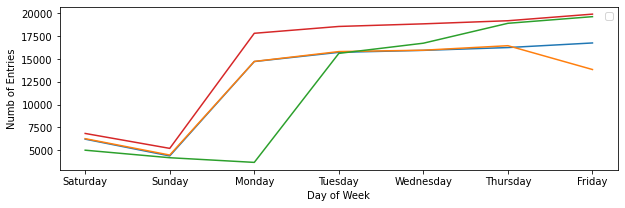

In [ ]:
plt.figure(figsize=(10,3))
plt.xlabel("Day of Week")
plt.ylabel("Numb of Entries")

for l in list_of_dailyentries_for_a_week:
  plt.plot(l["day_of_week"],l["DAILY_ENTRIES"])

plt.legend()
plt.show()

# Challenge 9
>Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [ ]:
df_daily_station.groupby(["STATION"])["DAILY_ENTRIES"].sum().reset_index().sort_values(["DAILY_ENTRIES"], ascending=False)

#for challenge 10
#reset index
#plot historgram


,STATION,DAILY_ENTRIES
61,34 ST-PENN STA,4609118.0
232,GRD CNTRL-42 ST,3997497.0
59,34 ST-HERALD SQ,3597977.0
46,23 ST,3274683.0
68,42 ST-PORT AUTH,3055070.0
...,...,...
147,BEACH 98 ST,18748.0
140,BEACH 105 ST,10509.0
161,BROAD CHANNEL,9422.0
299,NEWARK HM HE,4183.0


# Challenge Part 10


Histogram of total ridership.

Text(0.5, 0, 'Number of entries to that station')

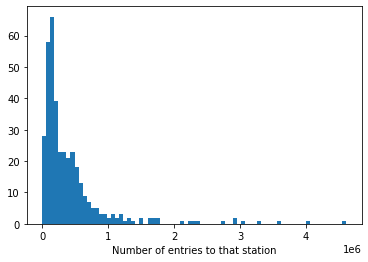

In [ ]:
plt.hist(df_daily_station.groupby(["STATION"])["DAILY_ENTRIES"].sum(), 75)
plt.xlabel(xlabel="Number of entries to that station")